# Initial Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

plt.style.use('seaborn-white')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)
plt.rc('font', family='serif')
plt.rc('font', family='serif')
plt.rcParams['image.cmap'] = 'Spectral'

In [2]:
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

In [3]:
import dm as diffusion_maps
import parsimonious
from subsample import subsample

In [4]:
start_time = datetime.now()

## Define the Governing ODE

In [5]:
def midlevel_MEK_ERK_model(x, t, k1, k2, k3, k4, k5, k6):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    dS0  = -k1*x[0]*x[5] + k2*x[1]
    dES0 =  k1*x[0]*x[5] - k2*x[1] - k3*x[1]
    dES1 =  k3*x[1] - k4*x[2] + k5*x[5]*x[3] - k6*x[2]
    dS1  =  k4*x[2] - k5*x[5]*x[3]
    dS2  =  k6*x[2]
    dE   = -k1*x[5]*x[0] + k2*x[1] + k4*x[2] - k5*x[5]*x[3] + k6*x[2]
    
    return [dS0, dES0, dES1, dS1, dS2, dE]

## Generate an Initial Sample

In [6]:
use_S2_only = True
generator = np.random.RandomState(12345)

num_samples = 5000
num_steps = 10
E0 = 0.66 # initial concentration of enzyme
C0 = np.array([5.0, 0.0, 0.0, 0.0, 0.0, E0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
time_points = np.linspace(0, 20, num_steps + 1)
delta_k = 0.1 # relative half-width of rate constant perturbations
rate_constants = np.zeros((num_samples, C0.size))
observations = np.zeros((num_samples, (1 if use_S2_only else 6)*num_steps)) # data to be used for DMaps

# Integrate the ODE for various (randomly perturbed) parameter values:
base_kvals = np.array([0.71, 19, 6700, 9200, 0.97, 5200])
for i in tqdm.trange(num_samples):
    kvals = base_kvals*generator.uniform(low = 1.0 - delta_k, high = 1.0 + delta_k, size = C0.size)
    sol = odeint(midlevel_MEK_ERK_model, C0, time_points, args = tuple(kvals))
    
    # Store rate constant values and observed concentrations:
    rate_constants[i,:] = kvals
    if use_S2_only:
        observations[i,:] = sol[1:,4]
    else:
        observations[i,:] = sol[1:,:]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Compute DMaps for Parameter Reduction

In [7]:
pw_dists = pdist(observations, "euclidean")
eps_par_red = 10.0*np.median(pw_dists**2) # scale parameter
dmap_par_red = diffusion_maps.SparseDiffusionMaps(points = observations,
                                                  epsilon = eps_par_red,
                                                  num_eigenpairs = 11,
                                                  cut_off = np.inf,  
                                                  renormalization = 0.0,
                                                  normalize_kernel = True)
phi = dmap_par_red.eigenvectors.T # dominant eigenvectors, including the trivial one

## Determine the Independent Components

Subsampling points.
Considering min_distance 0.020000.
Subsampling complete, taking 233 out of 5000 points.
Calculating 9 residuals


Calculating 9 residuals:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

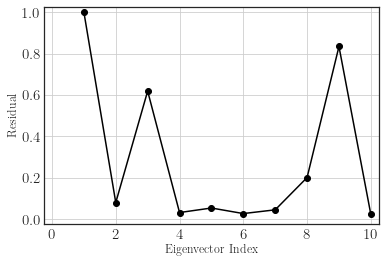

In [8]:
(subsampled_phi, idx_phi) = subsample(phi, min_distance = 0.02)
residuals = parsimonious.DiffusionMap.compute_residuals(subsampled_phi, eps_scale = 3.0)["Residuals"]
indices = np.where(residuals > 0.4)[0] # indices of non-harmonic eigenvectors

fig_residuals = plt.figure(figsize = (6, 4))
ax = fig_residuals.add_subplot(111)
ax.plot(range(1, subsampled_phi.shape[1]), residuals[1:], "ko-")
ax.set_xlim(-0.25, subsampled_phi.shape[1] - 0.75)
ax.set_ylim(-0.025, 1.025)
ax.set_xlabel("Eigenvector Index", fontsize = 12)
ax.set_ylabel("Residual", fontsize = 12)
ax.grid(True)

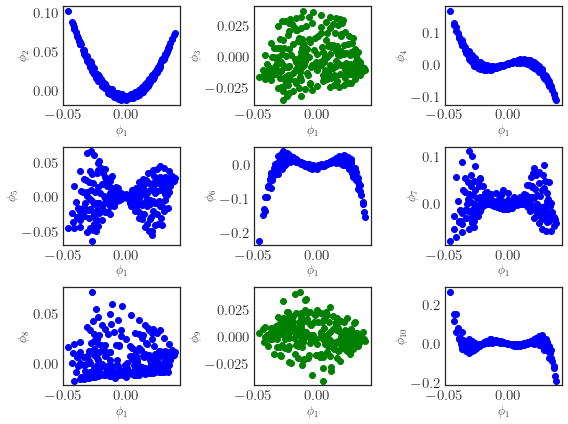

In [9]:
fig_dmaps_evecs = plt.figure(figsize = (8, 6));
for i in range (2,11):
    fmt = "go" if i in indices else "bo"
    ax = fig_dmaps_evecs.add_subplot(3, 3, i-1)
    ax.plot(phi[idx_phi,1], phi[idx_phi,i], fmt)
    ax.set_xlabel(r"$\phi_1$", fontsize = 12)
    ax.set_ylabel(r"$\phi_{%d}$" % i, fontsize = 12)
    ax.grid(False)
plt.tight_layout()

## Compare Data-Driven Observables with Theoretical Parameters

In [10]:
exact_K1 = E0*(rate_constants[:,0]*rate_constants[:,2])/(rate_constants[:,1] + rate_constants[:,2])
exact_K2 = E0*(rate_constants[:,5]*rate_constants[:,4])/(rate_constants[:,5] + rate_constants[:,3])
exact_PI = rate_constants[:,5]/(rate_constants[:,5] + rate_constants[:,3])

effective_params = np.array([exact_K1, exact_K2, exact_PI]).T # effective parameters
evecs = np.squeeze(phi[:,indices]) # eigenvectors

In [11]:
np.mean(effective_params,axis=0)

array([0.46754687, 0.23168523, 0.36160329])

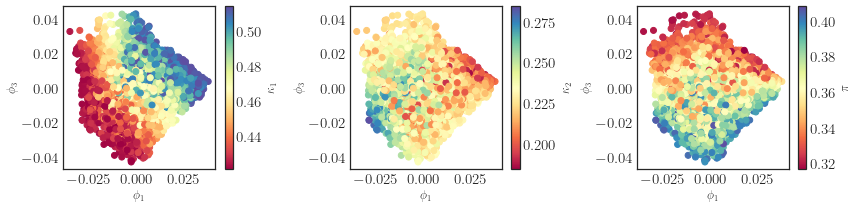

In [12]:
fig_compare_params = plt.figure(figsize = (12, 3))
for (k, lab) in enumerate([r"$\kappa_1$", r"$\kappa_2$", r"$\pi$"]):
    ax = fig_compare_params.add_subplot(131 + k)
    p = ax.scatter(evecs[:,1], evecs[:,2],
                   c = effective_params[:,k],
                   cmap = "Spectral",
                   rasterized = True)
    cs = plt.colorbar(p, ax = ax)
    cs.set_label(lab, fontsize = 12)
    ax.set_xlabel(r"$\phi_1$", fontsize = 12)
    ax.set_ylabel(r"$\phi_{%d}$" % indices[1], fontsize = 12)
plt.tight_layout()

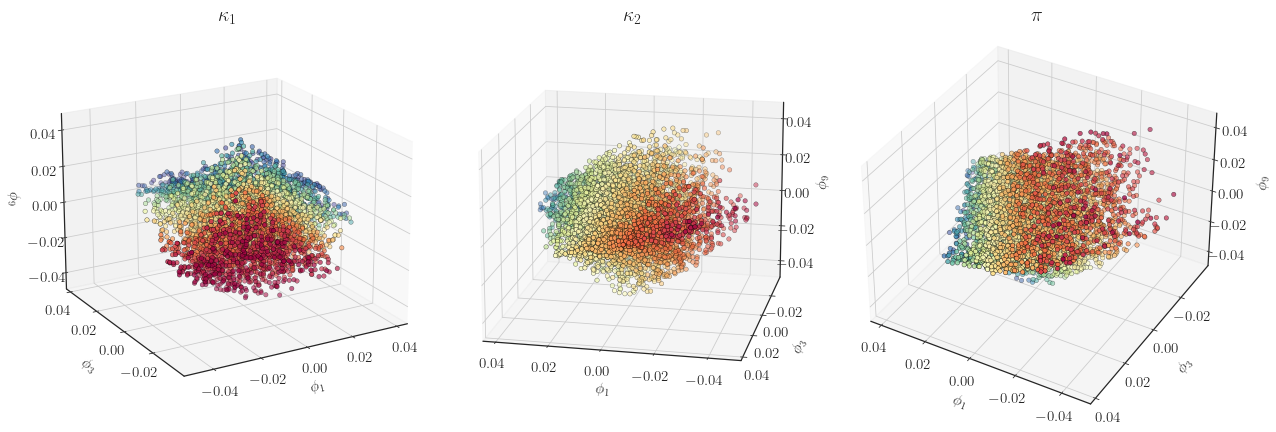

In [13]:
%matplotlib inline
fig_compare_params_3d = plt.figure(figsize = (17, 6.5))
labels = [r"$\kappa_1$", r"$\kappa_2$", r"$\pi$"];
for (k, lab) in enumerate([r"$\kappa_1$", r"$\kappa_2$", r"$\pi$"]):
    ax = fig_compare_params_3d.add_subplot(131 + k, projection = "3d")
    p = ax.scatter(*evecs.T,
                   c = effective_params[:,k],
                   cmap = "Spectral",
                   edgecolors= 'black',
                   linewidths= 0.4,
                   rasterized = True)
    #cs = plt.colorbar(p, ax = ax)
    #cs.set_label(lab, fontsize = 12)
    #ax.set_xticks(np.linspace(-0.04, 0.04, 5))
    ax.set_xlabel(r"$\phi_1$", fontsize = 15)
    #ax.set_yticks(np.linspace(-0.04, 0.04, 5))
    ax.set_ylabel(r"$\phi_{%d}$" % indices[1], fontsize = 15)
    #ax.set_zticks(np.linspace(-0.04, 0.04, 5))
    ax.set_zlabel(r"$\phi_{%d}$" % indices[2], fontsize = 15)
    ax.set_title(labels[k],fontsize = 20)
    ax.xaxis.labelpad=7
    ax.yaxis.labelpad=10
    ax.zaxis.labelpad=10
    if k == 0: ax.view_init(20, -120)
    if k == 1: ax.view_init(17, 102)
    if k == 2: ax.view_init(36, 120)


        
    plt.tight_layout()

# Compute DMaps for Interpolation

In [14]:
pw_dists = pdist(effective_params, "euclidean")
eps_interpolate = np.median(pw_dists**2)

(params_train, params_test, observations_train, observations_test) = train_test_split(effective_params, observations, train_size = 0.8)
dmap_interpolate = diffusion_maps.SparseDiffusionMaps(points = params_train,            
                                                      epsilon = eps_interpolate,             
                                                      num_eigenpairs = 100,
                                                      cut_off = np.inf,  
                                                      renormalization = 0.0,
                                                      normalize_kernel = False)
np.min(dmap_interpolate.eigenvalues)

5.4962210342436685e-05

## Build Interpolating Functions

In [15]:
obs0 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train,
                                                          epsilon = None,
                                                          values = observations_train[:,0], 
                                                          diffusion_maps = dmap_interpolate)

obs1 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train, 
                                                          epsilon = None,
                                                          values = observations_train[:,1], 
                                                          diffusion_maps = dmap_interpolate)

obs2 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train, 
                                                          epsilon = None,
                                                          values = observations_train[:,2], 
                                                          diffusion_maps = dmap_interpolate)

obs3 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train,
                                                          epsilon = None,
                                                          values = observations_train[:,3],
                                                          diffusion_maps = dmap_interpolate)

obs4 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train, 
                                                          epsilon = None,
                                                          values = observations_train[:,4] ,
                                                          diffusion_maps = dmap_interpolate)

obs5 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train, 
                                                          epsilon = None,
                                                          values = observations_train[:,5] ,
                                                          diffusion_maps = dmap_interpolate)


obs6 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train,
                                                          epsilon = None,
                                                          values = observations_train[:,6],
                                                          diffusion_maps = dmap_interpolate)

obs7 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train, 
                                                          epsilon = None,
                                                          values = observations_train[:,7] ,
                                                          diffusion_maps = dmap_interpolate)

obs8 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train, 
                                                          epsilon = None,
                                                          values = observations_train[:,8] ,
                                                          diffusion_maps = dmap_interpolate)

obs9 = diffusion_maps.GeometricHarmonicsInterpolator(points = params_train, 
                                                          epsilon = None,
                                                          values = observations_train[:,9] ,
                                                          diffusion_maps = dmap_interpolate)

## Compute the Interpolation Error

In [16]:
def rms_error(true_values, approximations, **kwargs):
    """
    Compute the root-mean-square error of a set of
    measurements, compared against true values.
    """
#     return np.sqrt(np.mean((true_values - approximations)**2.0, **kwargs))

# rms_train_K1 = rms_error(params_train[:,0], interp_K1(evecs_train))
# rms_train_K2 = rms_error(params_train[:,1], interp_K2(evecs_train))
# rms_train_PI = rms_error(params_train[:,2], interp_PI(evecs_train))
# print("Training RMS Error | K1: %9.3e | K2: %9.3e | PI: %9.3e" % (rms_train_K1, rms_train_K2, rms_train_PI))

# rms_test_K1 = rms_error(params_test[:,0], interp_K1(evecs_test))
# rms_test_K2 = rms_error(params_test[:,1], interp_K2(evecs_test))
# rms_test_PI = rms_error(params_test[:,2], interp_PI(evecs_test))
# print("    Test RMS Error | K1: %9.3e | K2: %9.3e | PI: %9.3e" % (rms_test_K1, rms_test_K2, rms_test_PI))

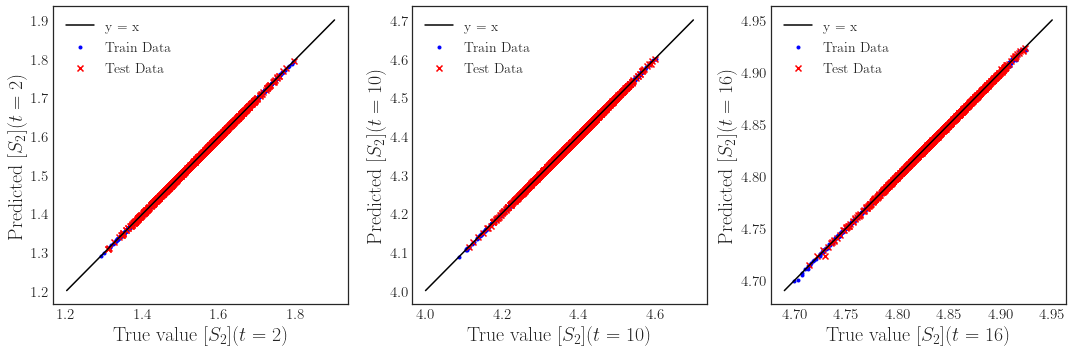

In [17]:
fig_compare_params = plt.figure(figsize = (5*3, 5))
ax = fig_compare_params.add_subplot(131)
p = ax.scatter(observations_train[:,0], obs0(params_train),marker = '.',c = 'b',label = 'Train Data')
p = ax.scatter(observations_test[:,0], obs0(params_test),marker = 'x', c = 'r',label = 'Test Data')
p = ax.plot(np.linspace(1.2,1.9,10),np.linspace(1.2,1.9,10),'k', label = 'y = x')
ax.set_xlabel("True value " + r'$[S_2](t=2)$')
ax.set_ylabel("Predicted " + r'$[S_2](t=2)$')
plt.legend(fontsize =14)
plt.tight_layout()

ax = fig_compare_params.add_subplot(132)
p = ax.scatter(observations_train[:,4], obs4(params_train),marker = '.',c = 'b',label = 'Train Data')
p = ax.scatter(observations_test[:,4], obs4(params_test),marker = 'x', c = 'r',label = 'Test Data')
p = ax.plot(np.linspace(4,4.7,10),np.linspace(4,4.7,10),'k', label = 'y = x')
ax.set_xlabel("True value " + r'$[S_2](t=10)$')
ax.set_ylabel("Predicted " + r'$[S_2](t=10)$')
plt.legend(fontsize =14)
plt.tight_layout()

ax = fig_compare_params.add_subplot(133)
p = ax.scatter(observations_train[:,7], obs7(params_train),marker = '.',c = 'b',label = 'Train Data')
p = ax.scatter(observations_test[:,7], obs7(params_test),marker = 'x', c = 'r',label = 'Test Data')
p = ax.plot(np.linspace(4.69,4.95,10),np.linspace(4.69,4.95,10),'k', label = 'y = x')
ax.set_xlabel("True value " + r'$[S_2](t=16)$')
ax.set_ylabel("Predicted " + r'$[S_2](t=16)$')
plt.legend(fontsize =14)
plt.tight_layout()

Text(0, 0.5, '$[S_2]$')

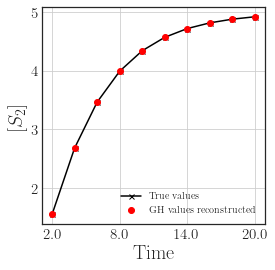

In [18]:
fig = plt.figure(figsize = (4,4))
plt.plot(np.linspace(2,20,10),observations_test[10,:],'x-k',markersize =5,label='True values')
plt.plot(time_points[1],obs0(params_test[10,:]),'or',label='GH values reconstructed')
plt.plot(time_points[2],obs1(params_test[10,:]),'or')
plt.plot(time_points[3],obs2(params_test[10,:]),'or')
plt.plot(time_points[4],obs3(params_test[10,:]),'or')
plt.plot(time_points[5],obs4(params_test[10,:]),'or')
plt.plot(time_points[6],obs5(params_test[10,:]),'or')
plt.plot(time_points[7],obs6(params_test[10,:]),'or')
plt.plot(time_points[8],obs7(params_test[10,:]),'or')
plt.plot(time_points[9],obs8(params_test[10,:]),'or')
plt.plot(time_points[10],obs9(params_test[10,:]),'or')
plt.grid()
x = np.linspace(2,20,4)
labels = np.linspace(2,20,4)

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels, rotation='horizontal')
plt.legend()
plt.xlabel('Time');plt.ylabel(r'$[S_2]$')

In [19]:
def observations_func (New):
    GH_Observations = np.array([obs0(New),obs1(New),obs2(New),obs3(New),
                               obs4(New),obs5(New),obs6(New),obs7(New),
                                obs8(New),obs9(New)]);         
    return GH_Observations

In [20]:
Full_Reconstuction  = observations_func(params_test).T
Full_Reconstuction.shape

(1000, 10)

In [21]:
Absolute_error_Reconst = np.linalg.norm(Full_Reconstuction - observations_test,axis=1)/np.linalg.norm(observations_test,axis=1)*100
Absolute_error_Reconst.shape

(1000,)

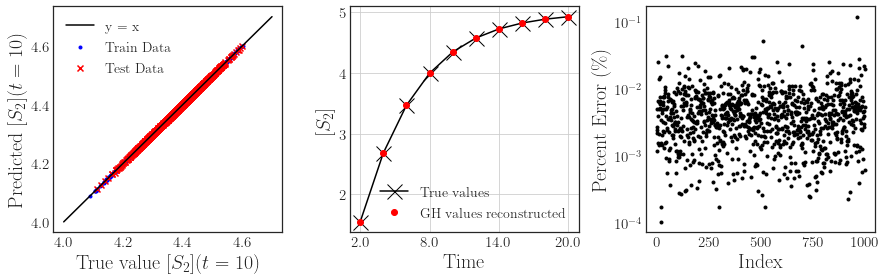

In [23]:
fig = plt.figure(figsize = (4*3.1,4))

plt.subplot(1,3,1)
plt.scatter(observations_train[:,4], obs4(params_train),marker = '.',c = 'b',label = 'Train Data')
plt.scatter(observations_test[:,4], obs4(params_test),marker = 'x', c = 'r',label = 'Test Data')
plt.plot(np.linspace(4,4.7,10),np.linspace(4,4.7,10),'k', label = 'y = x')
plt.xlabel("True value " + r'$[S_2](t=10)$')
plt.ylabel("Predicted " + r'$[S_2](t=10)$')
plt.legend(fontsize =14)
plt.tight_layout()


plt.subplot(1,3,2)
plt.plot(np.linspace(2,20,10),observations_test[10,:],'x-k',markersize =15,label='True values')
plt.plot(np.linspace(2,20,10),Full_Reconstuction[10,:],'or',label='GH values reconstructed')
plt.grid()
x = np.linspace(2,20,4)
labels = np.linspace(2,20,4)
plt.tight_layout()

# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels, rotation='horizontal')
plt.legend(fontsize =14)
plt.xlabel('Time');plt.ylabel(r'$[S_2]$')

plt.subplot(1,3,3)
plt.semilogy(Absolute_error_Reconst,'k.',markersize=6)
plt.xlabel('Index');
plt.ylabel('Percent Error (\%)')
plt.tight_layout()